# Comparing Latitude in actual data to E and temperature range

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as stats

%matplotlib inline

# BIOTRAITS DATA

In [2]:
# using all of the respiration data from biotraits, none of it is converted
respiration = pd.read_csv("../Data/biotraits/Respiration_ID_Ea_B0.csv")
# taking the absolute value of the latitude, so that I can fit a linear regression
respiration.Latitude = np.abs(respiration.Latitude)

## Fitted lnB0 in biotraits respiration data vs. latitude

Fitted slope of Absolute Latitude vs. lnB0: 0.0937654683652
R-squared value fo the fit: 0.000388926964878


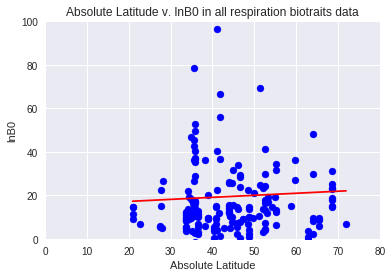

In [3]:
plt.scatter(respiration.Latitude, respiration.lnB0, color = 'blue')
plt.axis([0, 80, 0, 100])
plt.xlabel('Absolute Latitude')
plt.ylabel('lnB0')
plt.title('Absolute Latitude v. lnB0 in all respiration biotraits data')

X = respiration.Latitude
X = sm.add_constant(X)
Y = respiration.lnB0
fit = sm.OLS(Y, X).fit()

B = fit.params[0].astype('float')
m = fit.params[1].astype('float')
sim_vs_actual_fit_x = np.arange(min(respiration.Latitude), max(respiration.Latitude), 1)
sim_vs_actual_fit_y = m*sim_vs_actual_fit_x + B
plt.plot(sim_vs_actual_fit_x, sim_vs_actual_fit_y, color = 'red')

print('Fitted slope of Absolute Latitude vs. lnB0: ' + str(m))
print('R-squared value fo the fit: ' + str(fit.rsquared))

## Fitted E in biotraits respiration data vs. latitude

Fitted slope of Absolute Latitude vs. E: 0.00213174425223
R-squared value fo the fit: 0.000322775904598


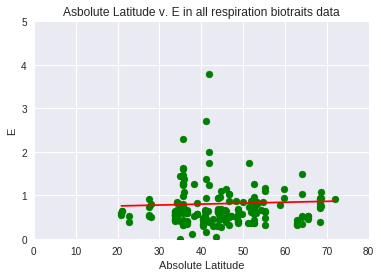

In [4]:
plt.scatter(respiration.Latitude, respiration.Ea, color = 'green')
plt.axis([0, 80, 0, 5])
plt.xlabel('Absolute Latitude')
plt.ylabel('E')
plt.title('Asbolute Latitude v. E in all respiration biotraits data')

X = respiration.Latitude
X = sm.add_constant(X)
Y = respiration.Ea
fit = sm.OLS(Y, X).fit()

B = fit.params[0].astype('float')
m = fit.params[1].astype('float')
sim_vs_actual_fit_x = np.arange(min(respiration.Latitude), max(respiration.Latitude), 1)
sim_vs_actual_fit_y = m*sim_vs_actual_fit_x + B
plt.plot(sim_vs_actual_fit_x, sim_vs_actual_fit_y, color = 'red')

print('Fitted slope of Absolute Latitude vs. E: ' + str(m))
print('R-squared value fo the fit: ' + str(fit.rsquared))

# MEDIAN-TEMPS-ONLY FLUXNET DATA

## Making data frame with E values and variances and temperature ranges of the fluxnet data

In [5]:
actual_df = pd.read_csv("../Results/median_temps/sites_boltz_fit_median_temps_only_results.csv")
fluxnet_df = pd.read_pickle("../Data/median_temps/fluxnet_median_temps_only.pkl")

# Making a data frame of the site IDs and their corresponding E simulated and E actual.

E_vals = pd.DataFrame({'siteID' : actual_df.site_ID, 'E_actual' : actual_df.E, 
                       'lat': actual_df.lat})

# removing any values that are Nan and the outlying E values (<= 0)
E_vals = E_vals[E_vals.siteID.notnull()]
E_vals = E_vals[E_vals.E_actual.notnull()]
E_vals = E_vals[(E_vals.E_actual > 0) & (E_vals.E_actual < 2)]

In [6]:
E_vals['abs_lat'] = np.abs(E_vals.lat)
E_vals['lat_range'] = [np.nan] * len(E_vals.abs_lat)
E_vals['var_E'] = [np.nan] * len(E_vals.abs_lat)
E_vals['var_E_actual'] = [np.nan] * len(E_vals.abs_lat)

E_vals.lat_range.loc[(E_vals.abs_lat > -1) & (E_vals.abs_lat <= 30)] = ['0-30 (Tropical Lat)'] * len(E_vals[(E_vals.abs_lat > -1) & (E_vals.abs_lat <= 30)].siteID)
E_vals.lat_range.loc[(E_vals.abs_lat > 30) & (E_vals.abs_lat <= 60)] = ['31-60 (Mid Lat)'] * len(E_vals[(E_vals.abs_lat > 30) & (E_vals.abs_lat <= 60)].siteID)
E_vals.lat_range.loc[(E_vals.abs_lat > 60) & (E_vals.abs_lat <= 90)] = ['61-90 (Upper Lat)'] * len(E_vals[(E_vals.abs_lat > 60) & (E_vals.abs_lat <= 90)].siteID)

trop_var_actual = np.var(E_vals.E_actual[E_vals.lat_range == '0-30 (Tropical Lat)'])
E_vals.loc[E_vals.lat_range == '0-30 (Tropical Lat)', 'var_E_actual'] = trop_var_actual

mid_var_actual = np.var(E_vals.E_actual[E_vals.lat_range == '31-60 (Mid Lat)'])
E_vals.loc[E_vals.lat_range == '31-60 (Mid Lat)', 'var_E_actual'] = mid_var_actual 

upper_var_actual = np.var(E_vals.E_actual[E_vals.lat_range ==  '61-90 (Upper Lat)'])
E_vals.loc[E_vals.lat_range == '61-90 (Upper Lat)', 'var_E_actual'] = upper_var_actual


/home/cmee10/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
E_vals['temp_range'] = [np.nan] * len(E_vals.abs_lat)
grouped = fluxnet_df.groupby('siteID')

for group, entries in grouped:
    min_temp = min(entries.TA_F_inKelvin)
    max_temp = max(entries.TA_F_inKelvin)
    temp_range = max_temp - min_temp 
    E_vals.loc[E_vals.siteID == group, 'temp_range'] = temp_range

## Comparing the fitted E values and their variance across absolute latitude

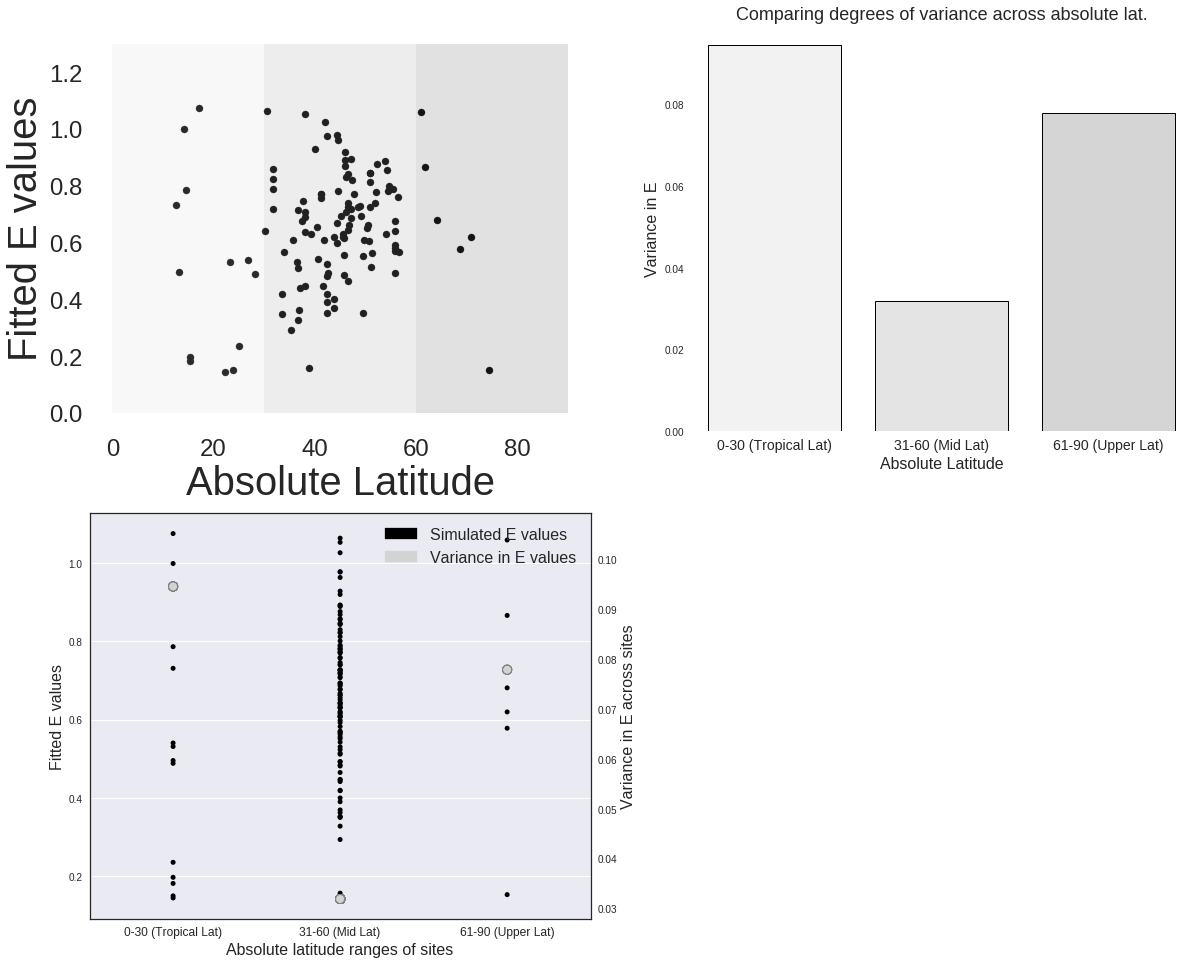

In [8]:
E_vals = E_vals.sort_values(by = 'lat_range', ascending = True)

#E_vals = E_vals.loc[E_vals.E_actual > 0.24]

fig, ax = plt.subplots(figsize = (16, 13))
fig.tight_layout()

ax1 = plt.subplot(2, 2, 1)
ax1.set_facecolor('white')
plt.fill([0, 30, 30, 0], [0, 0, 1.3, 1.3], 'gainsboro', alpha = 0.2)
plt.fill([30, 60, 60, 30], [0, 0, 1.3, 1.3], 'darkgray', alpha = 0.2)
plt.fill([60, 90, 90, 60], [0, 0, 1.3, 1.3], 'dimgray', alpha = 0.2)
plt.scatter(np.abs(E_vals.lat), E_vals.E_actual, color = 'black', s = 50)
#plt.title('Comparing Actual E values against absolute lat.', 
          #fontsize = 18)
plt.xlabel('Absolute Latitude', fontsize = 40)
plt.ylabel('Fitted E values', fontsize = 40)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
low_lat = mpatches.Patch(color='gainsboro', alpha = 0.2, label='Tropical Lats')
mid_lat = mpatches.Patch(color = 'darkgray', alpha = 0.2, label = 'Mid Lats')
upper_lat = mpatches.Patch(color = 'dimgray', alpha = 0.2, label = 'Upper Lats')
#plt.legend(bbox_to_anchor=(-0.1, 1.0), handles=[low_lat, mid_lat, upper_lat])

ax2 = plt.subplot(2, 2, 2)
ax2.set_facecolor('white')
pal = sns.light_palette("darkgray")
sns.barplot(E_vals.lat_range, E_vals.var_E_actual, palette = pal, linewidth = 1, edgecolor = 'black')
ax2.set_title('Comparing degrees of variance across absolute lat.', fontsize = 18)
ax2.set_ylabel('Variance in E', fontsize = 16)
ax2.set_xlabel('Absolute Latitude', fontsize = 16)
ax2.set_xticklabels(['0-30 (Tropical Lat)','31-60 (Mid Lat)', '61-90 (Upper Lat)'],fontsize = 14)

ax3 = plt.subplot(2, 2, 3)
sns.set_style('white')
sns.stripplot(E_vals.lat_range, E_vals.E_actual, color = 'black', label = 'E values')
ax3.set_xlabel('Absolute latitude ranges of sites', fontsize = 16)
ax3.set_xticklabels(['0-30 (Tropical Lat)','31-60 (Mid Lat)', '61-90 (Upper Lat)'],fontsize = 12)
ax3.set_ylabel('Fitted E values', fontsize = 16)
#ax3.set_title('Randomly sampled same number of sites \nfrom Mid lat and Tropical lat',
             #fontsize = 18)
ax4 = ax3.twinx()
sns.stripplot(E_vals.lat_range, E_vals.var_E_actual, color = 'lightgrey', size = 9, linewidth = 1)
ax4.set_ylabel('Variance in E across sites', fontsize = 16)

blue_patch = mpatches.Patch(color='black', label='Simulated E values')
black_patch = mpatches.Patch(color = 'lightgrey', label = 'Variance in E values')
plt.legend(handles=[blue_patch, black_patch], fontsize = 16)

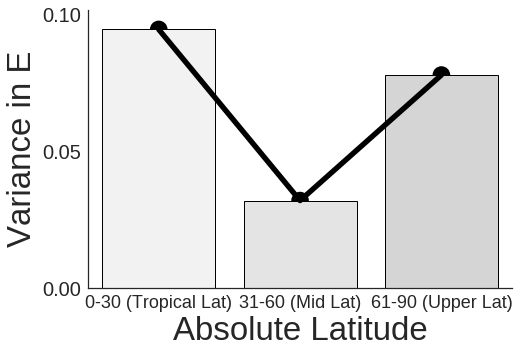

In [9]:
pal = sns.light_palette("darkgray")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 5}            
sns.set(font_scale=3, style = 'white', rc = paper_rc) 
ax2 = sns.FacetGrid(E_vals, size = 6, aspect = 1.5)
ax2 = ax2.map(sns.barplot, 'lat_range', 'var_E_actual', palette = pal, linewidth = 1, edgecolor = 'black')
ax2 = ax2.map(sns.pointplot,  'lat_range', 'var_E_actual', color = 'black')
ax2.set_axis_labels("Absolute Latitude","Variance in E")
ax2.set_xticklabels(['0-30 (Tropical Lat)','31-60 (Mid Lat)', '61-90 (Upper Lat)'],fontsize = 18)
p_trop_mid = 0.043565
ax2.set_yticklabels(fontsize = 20)

## Running F-test to check for same variance across groups

In [10]:
alpha = 0.05 #Or whatever you want your alpha to be.

F_trop_mid = trop_var_actual/mid_var_actual
F_mid_upper = mid_var_actual/upper_var_actual
F_trop_upper = trop_var_actual/upper_var_actual

df_trop = len(E_vals.loc[E_vals.lat_range == '0-30 (Tropical Lat)']) - 1
df_mid = len(E_vals.loc[E_vals.lat_range == '31-60 (Mid Lat)']) - 1
df_upper = len(E_vals.loc[E_vals.lat_range == '61-90 (Upper Lat)']) - 1

p_trop_midd = stats.f.cdf(F_trop_mid, df_trop, df_mid)
p_mid_upper = stats.f.cdf(F_mid_upper, df_mid, df_upper)
p_trop_upper = stats.f.cdf(F_trop_upper, df_trop, df_upper)


print('Mid vs. Upper: statistic = ' + str(F_mid_upper) + 'p: ' + str(p_mid_upper))
print('Tropical vs. Upper: statistic = ' + str(F_trop_upper) + 'p: ' + str(p_trop_upper))
print('Tropical vs. mid: statistic = ' + str(F_trop_mid) + 'p: ' + str(p_trop_mid))

Mid vs. Upper: statistic = 0.40994135953p: 0.0392535683439
Tropical vs. Upper: statistic = 1.21423500914p: 0.556244106324
Tropical vs. mid: statistic = 2.96197244047p: 0.043565


## Running a Bartlett's test for homogeneity of variance across the three latitudinal groups

In [11]:
trop_mid = stats.bartlett(E_vals.loc[E_vals.lat_range == '0-30 (Tropical Lat)', 'E_actual'], 
                        E_vals.loc[E_vals.lat_range == '31-60 (Mid Lat)', 'E_actual'])
trop_up = stats.bartlett(E_vals.loc[E_vals.lat_range == '0-30 (Tropical Lat)', 'E_actual'],
                       E_vals.loc[E_vals.lat_range == '61-90 (Upper Lat)', 'E_actual'])
mid_up = stats.bartlett(E_vals.loc[E_vals.lat_range == '31-60 (Mid Lat)', 'E_actual'],
                      E_vals.loc[E_vals.lat_range == '61-90 (Upper Lat)', 'E_actual'])

print("Tropical vs. Mid Lats Levene's test p-value : " + str(trop_mid[1]) + 
     "\nTropical vs. Upper Lats Levene's test p-value : " + str(trop_mid[1]) + 
     "\nMid vs. Upper Lats Levene's test p-value : " + str(mid_up[1]))

print(trop_mid)
print(mid_up)
print(trop_up)

Tropical vs. Mid Lats Levene's test p-value : 0.00215671647722
Tropical vs. Upper Lats Levene's test p-value : 0.00215671647722
Mid vs. Upper Lats Levene's test p-value : 0.0598207886595
BartlettResult(statistic=9.4111353124801127, pvalue=0.0021567164772179951)
BartlettResult(statistic=3.5423461833160346, pvalue=0.059820788659469319)
BartlettResult(statistic=0.01367000628483663, pvalue=0.90692439841961792)


# Same thing as above, but randomly selecting a subset of the mid-lats that is of the same size as the tropical lats (showing the above results are not just an artefact of oversampling the mid-lats)

In [12]:
E_vals = E_vals.reset_index(drop = True)

mid_indeces = pd.Series(E_vals[E_vals.lat_range == '31-60 (Mid Lat)'].index.values)
mid_indeces = mid_indeces.reset_index(drop = True)

import random 

random = random.sample(range(0, len(mid_indeces) - 1), 
                          (len(E_vals.var_E[E_vals.lat_range == '31-60 (Mid Lat)']) - len(E_vals.var_E[E_vals.lat_range == '0-30 (Tropical Lat)'])))

E_vals_subset = E_vals.drop(E_vals.index[mid_indeces.iloc[random]])

E_vals_subset.loc[E_vals_subset.lat_range == 
                '0-30 (Tropical Lat)', 'var_E_actual'] = np.var(E_vals_subset.E_actual[E_vals_subset.lat_range == 
                                                               '0-30 (Tropical Lat)'])
E_vals_subset.loc[E_vals_subset.lat_range == 
                '31-60 (Mid Lat)', 'var_E_actual'] = np.var(E_vals_subset.E_actual[E_vals_subset.lat_range == 
                                                                    '31-60 (Mid Lat)'])
E_vals_subset.loc[E_vals_subset.lat_range == 
                '61-90 (Upper Lat)', 'var_E_actual'] = np.var(E_vals_subset.E_actual[E_vals_subset.lat_range == 
                                                                    '61-90 (Upper Lat)'])

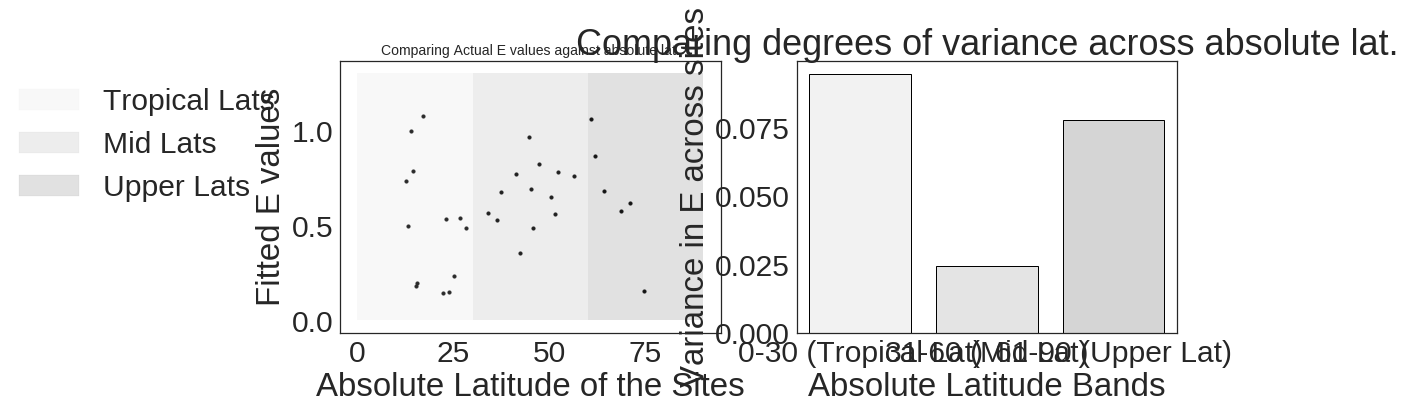

In [13]:
fig, ax = plt.subplots(figsize = (15, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor('white')
plt.fill([0, 30, 30, 0], [0, 0, 1.3, 1.3], 'gainsboro', alpha = 0.2)
plt.fill([30, 60, 60, 30], [0, 0, 1.3, 1.3], 'darkgray', alpha = 0.2)
plt.fill([60, 90, 90, 60], [0, 0, 1.3, 1.3], 'dimgray', alpha = 0.2)
plt.scatter(np.abs(E_vals_subset.lat[E_vals_subset.E_actual < 2]), 
            E_vals_subset.E_actual[E_vals_subset.E_actual < 2], color = 'black', s = 14)
plt.title('Comparing Actual E values against absolute lat.', 
          fontsize = 14)
plt.xlabel('Absolute Latitude of the Sites')
plt.ylabel('Fitted E values')

low_lat = mpatches.Patch(color='gainsboro', alpha = 0.2, label='Tropical Lats')
mid_lat = mpatches.Patch(color = 'darkgray', alpha = 0.2, label = 'Mid Lats')
upper_lat = mpatches.Patch(color = 'dimgray', alpha = 0.2, label = 'Upper Lats')
plt.legend(bbox_to_anchor=(-0.1, 1.0), handles=[low_lat, mid_lat, upper_lat])

ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor('white')
pal = sns.light_palette("darkgray")
sns.barplot(E_vals_subset.lat_range, E_vals_subset.var_E_actual, palette = pal, linewidth = 1, edgecolor = 'black')
ax2.set(title = 'Comparing degrees of variance across absolute lat.')
ax2.set(ylabel='Variance in E across sites')
ax2.set(xlabel = 'Absolute Latitude Bands')

In [14]:
trop_mid = stats.levene(E_vals_subset.E_actual[E_vals_subset.lat_range == '0-30 (Tropical Lat)'], 
                            E_vals_subset.E_actual[E_vals_subset.lat_range == '31-60 (Mid Lat)'])
mid_upper = stats.levene(E_vals_subset.E_actual[E_vals_subset.lat_range == '31-60 (Mid Lat)'], 
                       E_vals_subset.E_actual[E_vals_subset.lat_range == '61-90 (Upper Lat)'])
trop_upper = stats.levene(E_vals_subset.E_actual[E_vals_subset.lat_range == '61-90 (Upper Lat)'], 
                         E_vals_subset.E_actual[E_vals_subset.lat_range == '0-30 (Tropical Lat)'])

print(trop_mid)
print(mid_upper)
print(trop_upper)

LeveneResult(statistic=4.6674126160817702, pvalue=0.040942883701163904)
LeveneResult(statistic=1.5139203123596501, pvalue=0.2352963774696748)
LeveneResult(statistic=0.20026504407314813, pvalue=0.66015681745299837)


## Running a Bartlett's test for homogeneity of variance across the three latitudinal groups

In [15]:
stats.bartlett(E_vals_subset.loc[E_vals_subset.lat_range == '0-30 (Tropical Lat)', 'E_actual'], 
              E_vals_subset.loc[E_vals_subset.lat_range == '31-60 (Mid Lat)', 'E_actual'],
              E_vals_subset.loc[E_vals_subset.lat_range == '61-90 (Upper Lat)', 'E_actual'])

BartlettResult(statistic=5.1746374063008354, pvalue=0.075221460996416661)

## Running a post hoc Levene's test to see which of the lat groups have sig. diff. variances

In [16]:
trop_mid = stats.levene(E_vals_subset.loc[E_vals_subset.lat_range == '0-30 (Tropical Lat)', 'E_actual'], 
                        E_vals_subset.loc[E_vals_subset.lat_range == '31-60 (Mid Lat)', 'E_actual'])
trop_up = stats.levene(E_vals_subset.loc[E_vals_subset.lat_range == '0-30 (Tropical Lat)', 'E_actual'],
                       E_vals_subset.loc[E_vals_subset.lat_range == '61-90 (Upper Lat)', 'E_actual'])
mid_up = stats.levene(E_vals_subset.loc[E_vals_subset.lat_range == '31-60 (Mid Lat)', 'E_actual'],
                      E_vals_subset.loc[E_vals_subset.lat_range == '61-90 (Upper Lat)', 'E_actual'])

print("Tropical vs. Mid Lats Levene's test p-value : " + str(trop_mid[1]) + 
     "\nTropical vs. Upper Lats Levene's test p-value : " + str(trop_mid[1]) + 
     "\nMid vs. Upper Lats Levene's test p-value : " + str(mid_up[1]))

Tropical vs. Mid Lats Levene's test p-value : 0.0409428837012
Tropical vs. Upper Lats Levene's test p-value : 0.0409428837012
Mid vs. Upper Lats Levene's test p-value : 0.23529637747


# Comparing the temperature ranges at the sites vs. absolute latitude

Fitted slope of Absolute Latitude vs. temperature range: -0.0369725052887
R-squared value of the fit: 0.00764829714761
AIC of the fit: 741.79


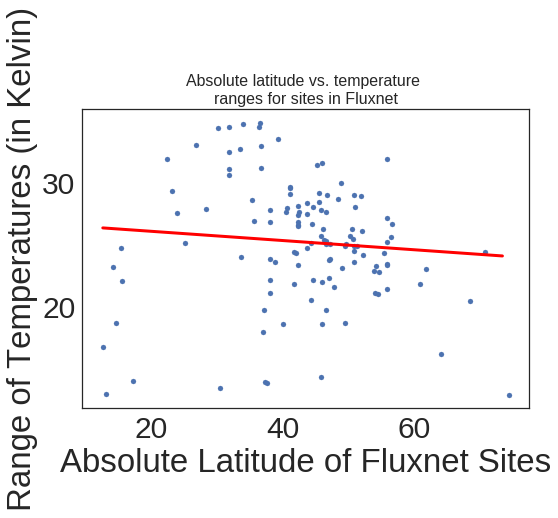

In [17]:
plt.scatter(E_vals.abs_lat, E_vals.temp_range)
plt.xlabel('Absolute Latitude of Fluxnet Sites')
plt.ylabel('Range of Temperatures (in Kelvin)')
plt.title('Absolute latitude vs. temperature \nranges for sites in Fluxnet', fontsize = 16)

X = E_vals.abs_lat
X = sm.add_constant(X)
Y = E_vals.temp_range
fit = sm.OLS(Y, X).fit()

B = fit.params[0].astype('float')
m = fit.params[1].astype('float')
sim_vs_actual_fit_x = np.arange(min(E_vals.abs_lat), max(E_vals.abs_lat), 1)
sim_vs_actual_fit_y = m*sim_vs_actual_fit_x + B
plt.plot(sim_vs_actual_fit_x, sim_vs_actual_fit_y, color = 'red')

print('Fitted slope of Absolute Latitude vs. temperature range: ' + str(m))
print('R-squared value of the fit: ' + str(fit.rsquared))
print('AIC of the fit: ' + str(round(fit.aic, 2)))

Polynomial fitted: -0.01x^2 + 0.66x + 13.98
R-squared value fo the fit: 0.153399152076


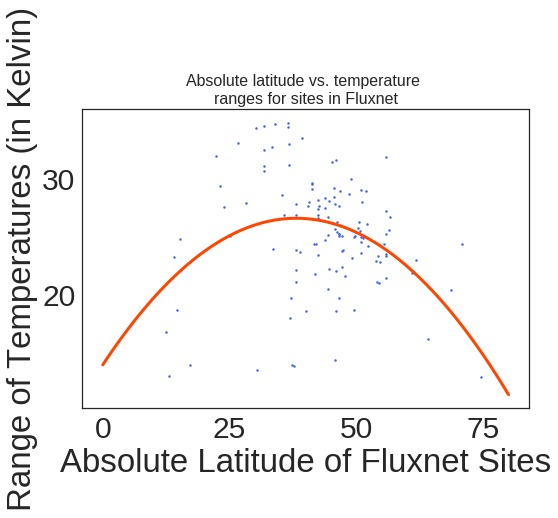

In [18]:
coeffs = np.polyfit(E_vals.abs_lat, E_vals.temp_range, 2)
p = np.poly1d(coeffs)
xp = np.linspace(0, 80, 100)

plt.plot(E_vals.abs_lat, E_vals.temp_range, '.', color = 'royalblue')
plt.plot(xp, p(xp), '-', color = 'orangered')
plt.xlabel('Absolute Latitude of Fluxnet Sites')
plt.ylabel('Range of Temperatures (in Kelvin)')
plt.title('Absolute latitude vs. temperature \nranges for sites in Fluxnet', fontsize = 16)

results = {}
# Polynomial Coefficients
results['polynomial'] = coeffs.tolist()


# fit values, and mean
yhat = p(E_vals.abs_lat)                         # or [p(z) for z in x]
ybar = np.sum(E_vals.temp_range)/len(E_vals.temp_range)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((E_vals.temp_range - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
results['determination'] = ssreg / sstot

print('Polynomial fitted: ' + str(round(results['polynomial'][0], 2)) + 'x^2 + ' + str(round(results['polynomial'][1], 2)) + 'x + ' + str(round(results['polynomial'][2], 2)))
print('R-squared value fo the fit: ' + str(results['determination']))

# Histograms for distributions of activation Energies in biotraits and fluxnet data

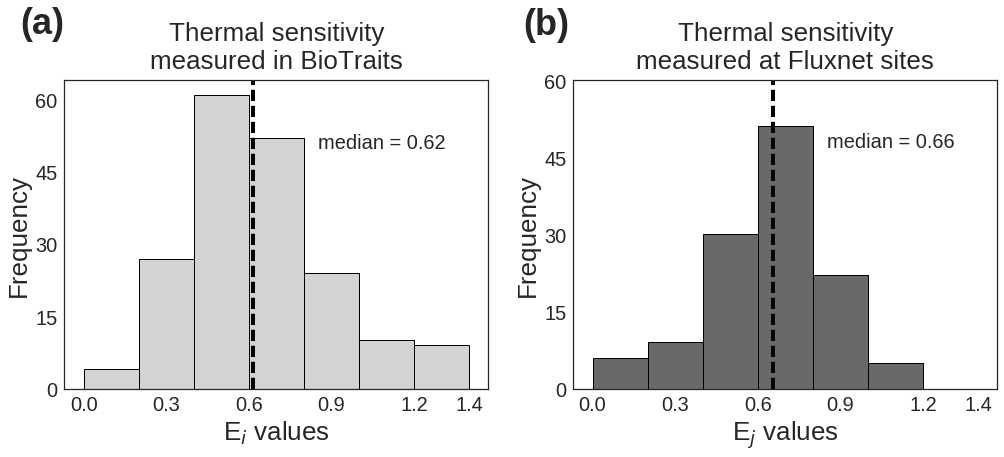

In [20]:
with plt.style.context("seaborn-white"): 
    fig, ax = plt.subplots(figsize = [15, 6])
    fig.tight_layout()
    
    sns.set(font_scale=1.5, style = 'white', rc = paper_rc) 
    binwidth = 0.2
    ax1 = plt.subplot(1, 2, 1)
    plt.hist(respiration.Ea[respiration.Ea < 2],  bins=np.arange(0, 1.25 + binwidth, binwidth), linewidth = 1, edgecolor = 'black', color = 'lightgrey')
    plt.xlabel('E$_i$ values', fontsize = 26)
    plt.ylabel('Frequency', fontsize = 26)

    plt.title('Thermal sensitivity\nmeasured in BioTraits', 
                  fontsize = 26, y=1.02)
   
    plt.xticks([0, 0.3, 0.6, 0.9, 1.2, 1.4], fontsize = 20)
    plt.yticks([0, 15, 30, 45, 60], fontsize = 20)
    plt.axvline(respiration.Ea[respiration.Ea < 2].median(), 
    color='k', linestyle='dashed', linewidth=4)
    plt.legend(fontsize = 18)
    plt.text(0.85, 50, 'median = ' + str(np.round(respiration.Ea[respiration.Ea < 2].median(), 2)), fontsize = 20)
    plt.text(-0.23, 73.8, '(a)', fontsize = 36, fontweight = 'bold')
    
    ax2 = plt.subplot(1, 2, 2)
    plt.hist(E_vals.E_actual,  bins=np.arange(0, 1.25 + binwidth, binwidth), linewidth = 1, edgecolor = 'black', color = 'dimgrey')
    plt.xlabel('E$_{j}$ values', fontsize = 26)
    plt.ylabel('Frequency', fontsize = 26)
    plt.title('Thermal sensitivity\nmeasured at Fluxnet sites', 
              fontsize = 26, y = 1.02)

    plt.xticks([0, 0.3, 0.6, 0.9, 1.2, 1.4], fontsize = 20)
    plt.yticks([0, 15, 30, 45, 60], fontsize = 20)
    plt.axvline(E_vals.E_actual.median(), 
    color='k', linestyle='dashed', linewidth=4)
    plt.text(0.85, 47, 'median = ' + str(np.round(E_vals.E_actual.median(), 2)), fontsize = 20)
    plt.text(-0.25, 69, '(b)', fontsize = 36, fontweight = 'bold')
    
         




